# TP -- Pracical work

### Table of Contents

* [Introduction](#introduction)
* [1. Analysing variability, capacity factors](#1.variability)
    * [Q1.1. Load factor (production/consumption)](#1.1.Question)
    * [Q1.2. Most simple dimensioning rules -- Lower and upper bound](#1.2.Question)
    * [Q1.3. Dimensioning -- Adding a storage](#1.3.Question)
* [2. Economic analysis, computing LCOE, system LCOE](#2.LCOE)
    * [Q2.1. LCOE of renewable + Flex system](#2.1.Question)
* [3. Optimisation of operation](#3.Operation)
    * [Q3.1. Optimisation results and Lagrange multipliers](#3.1.Question)
    * [Q3.2. Storage optimisation](#3.2.Question)
* [4. Optimisation of planning](#4.Planning)
    * [Q4.1. Optimisation results and Lagrange multipliers](#4.1.Question)



## Introduction <a class="anchor" id="introduction"></a>

Question asked here can generally be answered by copy-past of code given in folder "BasicFunctionalities" + small modifications/additions of yoru own.


In [2]:
import os
if os.path.basename(os.getcwd())=="SujetsDAnalyses":
    os.chdir('..') ## to work at project root  like in any IDE

InputFolder='Data/input/'

#region importation of modules
import numpy as np
import pandas as pd
import seaborn as sns
import csv
import datetime
import copy
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn import linear_model
from functions.f_operationModels import *
from functions.f_optimization import *
from functions.f_graphicalTools import *
import sys

#endregion

#region Solver and data location definition

InputFolder='Data/input/'

if sys.platform != 'win32':
    myhost = os.uname()[1]
else : myhost = ""
if (myhost=="jupyter-sop"):
    ## for https://jupyter-sop.mines-paristech.fr/ users, you need to
    #  (1) run the following to loanch the license server
    if (os.system("/opt/mosek/9.2/tools/platform/linux64x86/bin/lmgrd -c /opt/mosek/9.2/tools/platform/linux64x86/bin/mosek.lic -l lmgrd.log")==0):
        os.system("/opt/mosek/9.2/tools/platform/linux64x86/bin/lmutil lmstat -c 27007@127.0.0.1 -a")
    #  (2) definition of license
    os.environ["MOSEKLM_LICENSE_FILE"] = '@jupyter-sop'

BaseSolverPath='/Users/robin.girard/Documents/Code/Packages/solvers/ampl_macosx64' ### change this to the folder with knitro ampl ...
## in order to obtain more solver see see https://ampl.com/products/solvers/open-source/
## for eduction this site provides also several professional solvers, that are more efficient than e.g. cbc
sys.path.append(BaseSolverPath)
solvers= ['gurobi','knitro','cbc'] # try 'glpk', 'cplex'
solverpath= {}
for solver in solvers : solverpath[solver]=BaseSolverPath+'/'+solver
solver= 'mosek' ## no need for solverpath with mosek.
#endregion

from functions.f_consumptionModels import * #Il faut préciser le chemin où vous avez sauvegardé les données csv
from functions.f_graphicalTools import * #Il faut préciser le chemin où vous avez sauvegardé les données csv
#endregion



## 1. Analysing variability, capacity factors  <a class="anchor" id="1.variability"></a>
To answer questions here, you only need to understand thermal sensitivity manipulations explained in file BasicFunctionalities/input-Consumption.ipynb and
and know how to extract Availability data here : BasicFunctionalities/input-Availability.ipynb. You have to know the definition of capacity factor,
and the difference between installed power and energy produced. You can find the corresponding definitions in the first two sections of
the post [here](https://www.energy-alternatives.eu/2020/05/07/mix-de-production-delectricite-energie-et-puissance.html).

### Q1.1. Load factor (production/consumption)  <a class="anchor" id="1.1.Question"></a>

**Load factor of consumption**

From the available data, compute load factor of consumption mean($C_t$)/max($C_t$) [%]
for
 - year 2016 for different countries available,
 - years 2013-2017 and for various thermal sensitivity (ranging from zero to 2.5 GW/°C) in the case of France.

In [3]:
# year 2016 for different countries available
Zones="FR_DE_GB_ES"
year=2016 #only possible year

#### reading CSV files
areaConsumption = pd.read_csv(InputFolder+'areaConsumption'+str(year)+'_'+str(Zones)+'.csv',
                                sep=',',decimal='.',skiprows=0).set_index(["AREAS","TIMESTAMP"])
TemperatureThreshold = 15

LFC_regions = pd.DataFrame(columns = ['AREAS', 'LFC'])

for region in ["FR","DE","ES"]: ### problem with spain data
    ConsoTempeYear_df = areaConsumption.loc[(region,slice(None)),"areaConsumption"]

    
LFC_regions = LFC_regions.set_index(["AREAS"])
LFC_regions 


,LFC
AREAS,
FR,61.622162
DE,72.659660
ES,71.014027


In [4]:
# years 2013-2017 and for various thermal sensitivity (ranging from zero to 2.5 GW/°C) in the case of France.
ConsoTempe_df=pd.read_csv(InputFolder+'ConsumptionTemperature_1996TO2019_FR.csv')
ConsoTempe_df["TIMESTAMP"]=pd.to_datetime(ConsoTempe_df['Date'])
ConsoTempe_df=ConsoTempe_df.drop(columns=["Date"]).set_index(["TIMESTAMP"])


years = list(range(2013, 2018))
TemperatureThreshold = 14

LFC_years = pd.DataFrame(columns = ['YEAR', "THERMOSENSITIVITY", 'LFC'])

for year in years:
    #Generic function Thermal sensitivity estimation
    ConsoTempeYear_df=ConsoTempe_df[str(year)]
    for Thermosensibilite0 in np.arange(0,-2.6,-0.1):
        Thermosensibilite0 *= 1000
        Thermosensibilite = {i:Thermosensibilite0 for i in range(0,24)}
        (ConsoTempeYear_decomposed_df, NA) = Decomposeconso(ConsoTempeYear_df, TemperatureThreshold=TemperatureThreshold)
        ConsoSepareeNew_df = Recompose(ConsoTempeYear_decomposed_df, Thermosensibilite,
                                 Newdata_df = ConsoTempeYear_df,
                                 TemperatureThreshold = TemperatureThreshold)
        LFC = 100*ConsoSepareeNew_df["Consumption"].mean()/ConsoSepareeNew_df["Consumption"].max()
        LFC_years.loc[len(LFC_years)] = [year, Thermosensibilite0, LFC]

THERMOSENSITIVITY    -2500.0    -2400.0    -2300.0    -2200.0    -2100.0  \
YEAR                                                                       
2013.0             59.476564  59.986612  60.513212  61.057181  61.619394   
2014.0             58.667080  59.152004  59.650473  60.163062  60.690379   
2015.0             57.116718  57.581953  58.054717  58.531040  59.021116   
2016.0             61.144696  61.595462  62.058970  62.535770  63.026441   
2017.0             56.463800  56.940229  57.431248  57.937536  58.459817   

THERMOSENSITIVITY    -2000.0    -1900.0    -1800.0    -1700.0    -1600.0  ...  \
YEAR                                                                      ...   
2013.0             62.200784  62.802348  63.425157  64.070355  64.739171  ...   
2014.0             61.233070  61.791816  62.164925  62.520927  62.885167  ...   
2015.0             59.525550  60.044980  60.580087  61.131590  61.700256  ...   
2016.0             63.531599  64.051892  64.588014  65.140696 

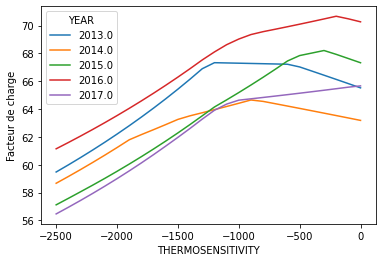

In [77]:
LFC_years
LFC_years2 = LFC_years.pivot(index='YEAR', columns='THERMOSENSITIVITY')['LFC']
LFC_years2.T.plot()
plt.ylabel('Facteur de charge')
print(LFC_years2)

**Load factor of Wind Power and PV production**

Compute load factor of renewable production (PV/Wind) for different years/countries that are available (see input-Availability.ipynb).

In [72]:
#region multi zone
Zones="FR_DE_GB_ES"
year=2016
techs = ['WindOnShore', 'Solar']

LFC_availability = pd.DataFrame(columns = ['REGION', "TECH", 'LFC'])

for MyTech in techs:
    ### 'Thermal' 'OldNuke' 'HydroRiver' 'HydroReservoir' 'WindOnShore' 'Solar'
     #'NewNuke', 'HydroRiver', 'HydroReservoir','WindOnShore', 'WindOffShore', 'Solar', 'Curtailement'}

    #### reading CSV files
    availabilityFactor = pd.read_csv(InputFolder+'availabilityFactor'+str(year)+'_'+str(Zones)+'.csv',
                                    sep=',',decimal='.',skiprows=0)
    availabilityFactor0 = availabilityFactor[availabilityFactor['TECHNOLOGIES'] == MyTech]

    for region in ["FR","DE","GB"]: ### problem with spain data
        tabl=availabilityFactor0[availabilityFactor0['AREAS']==region]
        LFC = 100*tabl["availabilityFactor"].mean()/tabl["availabilityFactor"].max()
        LFC_availability.loc[len(LFC_availability)] = [region, MyTech, LFC]

TECH        Solar  WindOnShore
REGION                        
DE      15.033732    23.024143
FR      17.747565    26.594428
GB      16.292252    32.115316


Text(0, 0.5, 'Facteur de charge')

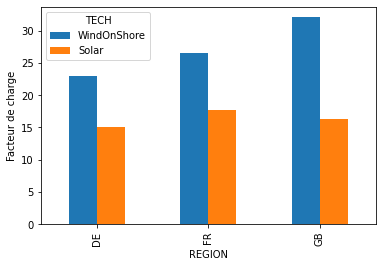

In [73]:
LFC_availability
LFC_availability2 = LFC_availability.pivot(index='REGION', columns='TECH')['LFC']
print(LFC_availability2)
LFC_availability2.plot(y=techs, kind="bar")
plt.ylabel('Facteur de charge')

**"Load factor" of nuclear availability**

Compute the "load factor" of nuclear availability for year 2007 to 2016.

In [69]:
#region Disponibilité sur la France période 2013-2016
region = "FR"
years = list(range(2013, 2017))
techs = ['OldNuke', 'NewNuke']

LFC_availability_nuclear = pd.DataFrame(columns = ['YEAR', "TECH", 'LFC'])

for MyTech in techs:
    for year in years:
        #### reading CSV files
        availabilityFactor = pd.read_csv(InputFolder+'availabilityFactor'+str(year)+'_'+str(region)+'.csv',
                                    sep=',',decimal='.',skiprows=0)
        availabilityFactor0 = availabilityFactor[availabilityFactor['TECHNOLOGIES'] == MyTech]

        LFC = 100*availabilityFactor0["availabilityFactor"].mean()/availabilityFactor0["availabilityFactor"].max()
        LFC_availability_nuclear.loc[len(LFC_availability_nuclear)] = [year, MyTech, LFC]

TECH  NewNuke    OldNuke
YEAR                    
2013      NaN  80.118043
2014      NaN  81.614174
2015      NaN  81.357374
2016      NaN  75.575799


Text(0, 0.5, 'Facteur de charge')

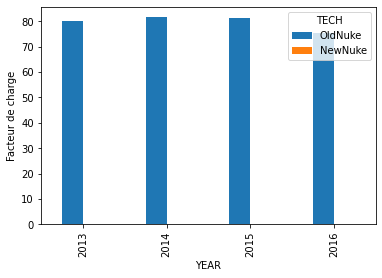

In [71]:
LFC_availability_nuclear
LFC_availability_nuclear2 = LFC_availability_nuclear.pivot(index='YEAR', columns='TECH')['LFC']
print(LFC_availability_nuclear2)
LFC_availability_nuclear2.plot(y=techs, kind="bar")
plt.ylabel('Facteur de charge')


### Q1.2. Most simple dimensioning rules -- Lower and upper bound  <a class="anchor" id="1.2.Question"></a>

 **a -- Lower bound**

How much power of XXX power would you need to install in LLL to have an **annual energy** produced equal to the annual energy consummed in year YYY ?
 Answer this question for XXX = {Wind, PV, Nuke}, LLL =available country and YYY available year.

In [14]:
# Put your answer here


TECHNOLOGIES  HydroReservoir  HydroRiver   OldNuke  Solar  Thermal  \
TIMESTAMP                                                            
1                        1.0    0.446046  0.928560    0.0      1.0   
2                        1.0    0.434063  0.928560    0.0      1.0   
3                        1.0    0.388382  0.928560    0.0      1.0   
4                        1.0    0.347019  0.928560    0.0      1.0   
5                        1.0    0.342092  0.928560    0.0      1.0   
...                      ...         ...       ...    ...      ...   
8756                     1.0    0.702555  0.898972    0.0      1.0   
8757                     1.0    0.559915  0.898972    0.0      1.0   
8758                     1.0    0.477251  0.898972    0.0      1.0   
8759                     1.0    0.435706  0.898972    0.0      1.0   
8760                     1.0    0.494647  0.898972    0.0      1.0   

TECHNOLOGIES  WindOnShore  
TIMESTAMP                  
1                0.583934  
2    

 **b -- Upper bound**

How much power of XXX power would you need to install in LLL to have an **hourly energy** produced equal to the hourly energy consummed in year YYY ?
 Answer this question for XXX = {Wind, Nuke}, LLL =available country and YYY available year.
 Assuming that for all hours of the year the excess of production is lost, what would be the capacity factor of productions in this cases

In [ ]:
# Put your answer here


 **c -- Sensitivity of the result to thermal sensitivity of consumption**

 For year 2016 and in France, analyse the sensitivity of the preceding results (upper bound and lower bound) on the thermal sensitivity of consumption

In [ ]:
# Put your answer here


### Q1.3 Dimensioning -- Adding a storage <a class="anchor" id="1.3.Question"></a>
These questions are much more difficult than the preceding ones. It is possible that no student will manage to do it during the practical work session.

**a - Dimensioning a system with Renewable + "infinite storage"**

We now assume we have a theoretical storage with
 - infinite energy capacity (can store for hours without being full start with an initial capacity to discuss)
 - a maximum production power (of the storage) that will be equal to the maximum consumption power (of the storage)
 - These maximum power are supposed ajusted so that $C_t\leq P_t+S_t$ for all hours $t$ of the considered year
 (With $C$ the consumption,$P$ the wind power production, $S$ the storage production. $S$ can be negative when it is a consumption)
 - an efficiency $\eta=70%$



Try to compute :
 - installed power of wind and storage,
 - losses of wind energy through the storage
 - losses of wind energy that cannot be stored of consumed directly.

In [ ]:
# Put your answer here


**b -adding french hydro power**

 In the preceding system, you can add french hydro production (the data can be found in Eco2mix section of input-Availability.ipynb)

In [ ]:
# Put your answer here

**c -sensitibvity to thermal sensitivity**

 What is the sensitivity of the preceding results to thermal sensitivity of consumption

In [ ]:
# Put your answer here

** d -Adding PV **
In the preceding system, assume now you can mix PV and wind. What can you gain ?

In [ ]:
# Put your answer here


If you finish all this before the end of the first session, of if you wish to dig a little bit more, you can read [this article](https://jancovici.com/transition-energetique/renouvelables/100-renouvelable-pour-pas-plus-cher-fastoche/)
and discuss the dimensioning choice for the storage that is proposed there. Otherwise, or after that, you can switch to question 2.

## 2. Economic analysis, computing LCOE, system LCOE <a class="anchor" id="2.LCOE"></a>

### Q2.1. LCOE of renewable + Flex system <a class="anchor" id="2.1.Question"></a>
Read and understand jupyter notebook optim-Operation.ipynb.
Try to imagine systems that are feasible and compute the corresponding system LCOE in the two following cases:
- Nuke + CCG + hydro
- Renewable + CCG + hydro
You will need to set the installed power and produced energy for each of these production mean. Try to get inspiration from preceding section.
There are no "right answer", the idea here is to have rough estimates that will be improved later.
Try adding significant amount of electrolyser/fuel cells to replace CCG. How much capacity would you install and see how it changes the results ?
Try changing the thermal sensitivity of consumption.
You can also analyse the effect of discount rate, or carbon tax, or cost of gaz (by assumign e.g. it is a very expensive biogaz).

In [99]:
# Get the data
General = pd.read_csv(InputFolder+'GeneralEconomicAssumptions.csv',sep=',',decimal='.',skiprows=0,comment="#")

Production = pd.read_csv(InputFolder+'ProductionEconomicAssumptions.csv',sep=',',decimal='.',skiprows=0,comment="#")
Production=Production[Production["AREAS"]=="FR"]

r=(General.discountPercent[0]/100)
Production=Production.assign(
    LLr = round((1+r)/r*(1-(1+r)**(-Production['LL'])),2),
    capacityCost = round(Production.CAPEX/Production.LL+ Production.dismantling/(1+r)**(Production.LL) +Production.FOM,2)*1000,
    energyCost = round(Production.Variable + Production.CO2Emission*General.carbonTaxEurosPerT[0]/10**6,2)
)

#region - general economic assumption
ProductionTech = pd.read_csv(InputFolder+'ProductionTechnicalAssumptions.csv',sep=',',decimal='.',skiprows=0,comment="#")
ProductionTech=ProductionTech[ProductionTech["AREAS"]=="FR"]
ProductionTechPlus=ProductionTech.merge(Production, how='inner', left_on=["AREAS","TECHNOLOGIES"], right_on=["AREAS","TECHNOLOGIES"])
# ------------------------------------------------------------------------------------------------------------------------------------

# mytechs = ["OldNuke", "CCG", "HydroReservoir", "Solar", "WindOnShore", "WindOffShore"]
# ProductionTechPlus = ProductionTechPlus[ProductionTechPlus["TECHNOLOGIES"].isin(mytechs)]

# On rend la data plus compacte
df = ProductionTechPlus.copy()
df["capacity"] /= 1000
df.drop(df.columns[[0,1,5,6,7,8,9,10]], axis=1, inplace=True)
df.set_index("TECHNOLOGIES", inplace=True)

# Capex du nucleaire
df.at["OldNuke", "CAPEX"] = 3000

# On calcule le LCOE (en €/MWh)
df["LCOE"] = (df.CAPEX/df.LLr + df.dismantling/((1+r)**(df.LL)) + df.FOM) * (df.capacity/(df.ProducedEnergy)) + df.Variable

# On ajoute une colonne facteur de charge
df["FC"] = df.ProducedEnergy / (8.76 * df.capacity)

df

,capacity,ProducedEnergy,CAPEX,dismantling,Variable,FOM,LL,CL,CO2Emission,LLr,capacityCost,energyCost,LCOE,FC
TECHNOLOGIES,,,,,,,,,,,,,,
TAC,4.0,3.2,600,100,60,36,30,2,600,17.98,86830.0,60.02,185.252848,0.091324
Coal,2.0,1.0,1100,100,40,36,30,2,1000,17.98,103500.0,40.04,296.021909,0.057078
CCG,12.0,38.6,900,100,50,36,30,2,470,17.98,96830.0,50.02,86.338078,0.367199
OldNuke,63.0,413.0,3000,1000,7,150,60,0,0,23.53,245060.0,7.00,63.830761,0.748351
NukeCarrene,0.0,0.0,1587,1000,7,200,60,0,0,23.53,321510.0,7.00,NaN,NaN
NewNuke,0.0,0.0,4000,1000,7,200,60,10,0,23.53,361730.0,7.00,NaN,NaN
WindOnShore,14.9,29.0,1300,50,0,45,30,2,0,17.98,103750.0,0.00,68.189846,0.222181
WindOffShore,0.0,0.0,2500,100,0,114,30,3,0,17.98,228170.0,0.00,NaN,NaN
HydroReservoir,7.0,33.0,1500,10,0,20,80,10,0,24.87,39180.0,0.00,17.128252,0.538160


In [100]:
df = df.reset_index()

In [119]:
# ------------------------------------------------------------------------------------------------------------------------------------
# scénario 1
mytechs = ["OldNuke", "CCG", "HydroReservoir", "HydroRiver"]
df1 = df[df["TECHNOLOGIES"].isin(mytechs)].copy()
df1.set_index("TECHNOLOGIES", inplace=True)

# on calcule la moyenne pondérée des LCOE
df1["LCOEm"] = df1.LCOE * df1.ProducedEnergy / sum(df1["ProducedEnergy"])

print("LCOE moyen :", sum(df1["LCOEm"]))
df1

LCOE moyen : 60.37205854459385


,capacity,ProducedEnergy,CAPEX,dismantling,Variable,FOM,LL,CL,CO2Emission,LLr,capacityCost,energyCost,LCOE,FC,LCOEm
TECHNOLOGIES,,,,,,,,,,,,,,,
CCG,12.0,38.6,900,100,50,36,30,2,470,17.98,96830.0,50.02,86.338078,0.367199,6.476195
OldNuke,63.0,413.0,3000,1000,7,150,60,0,0,23.53,245060.0,7.00,63.830761,0.748351,51.228341
HydroReservoir,7.0,33.0,1500,10,0,20,80,10,0,24.87,39180.0,0.00,17.128252,0.538160,1.098392
HydroRiver,10.0,30.0,1500,10,0,20,80,10,0,24.87,39180.0,0.00,26.915825,0.342466,1.569131


In [121]:
# ------------------------------------------------------------------------------------------------------------------------------------
# scénario 2 # 35 gaz, 170 eolien, hydro 25, pv 100
mytechs = ["CCG", "HydroReservoir", "HydroRiver", "Solar", "WindOnShore"]
df2 = df[df["TECHNOLOGIES"].isin(mytechs)].copy()
df2.set_index("TECHNOLOGIES", inplace=True)
df2.at["CCG", "capacity"] = 35
df2.at["WindOnShore", "capacity"] = 120
df2.at["HydroReservoir", "capacity"] = 15
df2.at["HydroRiver", "capacity"] = 10
df2.at["Solar", "capacity"] = 70

# On calcule l'énergie produite avec le FC
df2["ProducedEnergy"] = (8.76 * df2.capacity) * df2.FC

# On calcule le LCOE (en €/MWh)
df2["LCOE"] = (df2.CAPEX/df2.LLr + df2.dismantling/((1+r)**(df2.LL)) + df2.FOM) * (df2.capacity/(df2.ProducedEnergy)) + df2.Variable

# on calcule la moyenne pondérée des LCOE
df2["LCOEm"] = df2.LCOE * df2.ProducedEnergy / sum(df2["ProducedEnergy"])

print("LCOE moyen :", sum(df2["LCOEm"]))
df2

LCOE moyen : 63.1784694663786


,capacity,ProducedEnergy,CAPEX,dismantling,Variable,FOM,LL,CL,CO2Emission,LLr,capacityCost,energyCost,LCOE,FC,LCOEm
TECHNOLOGIES,,,,,,,,,,,,,,,
CCG,35.0,112.583333,900,100,50,36,30,2,470,17.98,96830.0,50.02,86.338078,0.367199,18.442252
WindOnShore,120.0,233.557047,1300,50,0,45,30,2,0,17.98,103750.0,0.00,68.189846,0.222181,30.216917
HydroReservoir,15.0,70.714286,1500,10,0,20,80,10,0,24.87,39180.0,0.00,17.128252,0.538160,2.298040
HydroRiver,10.0,30.000000,1500,10,0,20,80,10,0,24.87,39180.0,0.00,26.915825,0.342466,1.532027
Solar,70.0,80.208333,800,30,0,20,25,1,0,16.25,63250.0,0.00,70.240820,0.130803,10.689233


## 3. Optimisation of operation <a class="anchor" id="3.Operation"></a>

### Q3.1. Optimisation results and Lagrange multipliers <a class="anchor" id="3.1.Question"></a>
Read and understand jupyter notebook optim-Operation.ipynb. Can you explain the value of all lagrange multiplier in a simple case with two production means ?
With one area and then with two. How is it possible to generate negative lagrange multipliers ? Propose a simple case where they appear and explain the corresponding values.


In [ ]:
# Put your answer here

### Q3.2. Storage optimisation <a class="anchor" id="3.2.Question"></a>
Read and understand jupyter notebook optim-storage.ipynb. What is the maximal price for the storage system to be profitable today ?
Apply an homothetic transformation to increase the variance of the prices but without changing the mean (and by keeping positive prices).
How does it change the preceding results ?

In [ ]:
# Put your answer here


## 4. Optimisation of planning <a class="anchor" id="4.Planning"></a>

### Q4.1. Optimisation results and Lagrange multipliers <a class="anchor" id="4.1.Question"></a>

**a - System LCOE**

Read and understand jupyter notebook optim-storage.ipynb. Try using it to adapt your answer to Q2.1.

In [ ]:
# Put your answer here

**a - Loss of load expectation**

Today the expected loss of load is of 3 hours in average per year, try to find how to set the variable cost of "curtailment"
(consumption that is cut, the cost is initially set to 3000 €/MWh) to have the value of this expected number at 3.1.
Try to find in the CRE or RTE or ENEDIS website the "official value" in France.

In [ ]:
# Put your answer here